In [ ]:
!python src/modeling/train_model.py

# Set up

In [44]:
from src.config.config import *

In [47]:

def get_train_val_test_generator(train_path, val_path, test_path, batch_size=32):
    """
    Return training, validation and test generator
    """
    train_generator = ImageDataGenerator(rescale=1./255,
                                         rotation_range=20,
                                         zoom_range=0.05,
                                         width_shift_range=0.1,
                                         height_shift_range=0.1,
                                         shear_range=0.05,
                                         horizontal_flip=True,
                                         vertical_flip=True,
                                         fill_mode = "nearest" )
    val_test_generator = ImageDataGenerator(rescale=1./255)    

    train_gen = train_generator.flow_from_directory(directory=train_path, 
                                                    class_mode='categorical',
                                                    target_size=(48,48),
                                                    color_mode='rgb',
                                                    shuffle=True,
                                                    batch_size=batch_size) 


    val_gen = val_test_generator.flow_from_directory(directory=val_path,
                                                class_mode="categorical",
                                                target_size=(48, 48),
                                                color_mode="rgb",
                                                shuffle=False,
                                                batch_size=batch_size)

    test_gen = val_test_generator.flow_from_directory(directory=test_path,
                                                class_mode="categorical",
                                                target_size=(48, 48),
                                                color_mode="rgb",
                                                shuffle=False,
                                                batch_size=batch_size)


    return train_gen, val_gen, test_gen

In [49]:
train_gen, val_gen, test_gen = get_train_val_test_generator(TRAIN_PATH, VAL_PATH, TEST_PATH
                                                          )

Found 14912 images belonging to 2 classes.
Found 1656 images belonging to 2 classes.
Found 4142 images belonging to 2 classes.


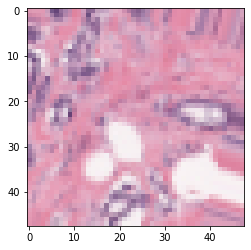

In [50]:
x, y = train_gen.__getitem__(0)
plt.imshow(x[0])

In [3]:
cd /content/drive/MyDrive/breast-cancer-classification

/content/drive/MyDrive/breast-cancer-classification


In [31]:
import tensorflow as tf
from imutils import paths
import random, shutil, os

import matplotlib.pyplot as plt
import numpy as np

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical


# Dataset

IDC (Invasive Ductal Carcinoma) dataset that is the most common of all breast cancer. 

This dataset contains 277,524 patches of 50x50 pixels:
- 198,738 negative examples (no breast cancer)
- 78,786 positve examples (breast cancer was found)

Each image in dataset has a specific filename structure. An example is below:
<code>10253_idx5_x1351_y1101_class0.png</code>
Where:
- patientID: <code>10253_idx5</code>
- x_coorinate of the crop: <code>1,351</code>
- y-coordinate of the crop: <code>1,101</code>
- class label: <code>0</code> (no breast cancer) while <code>1</code> (breast cancer)

This below image shows examples of both positive and negative samples:


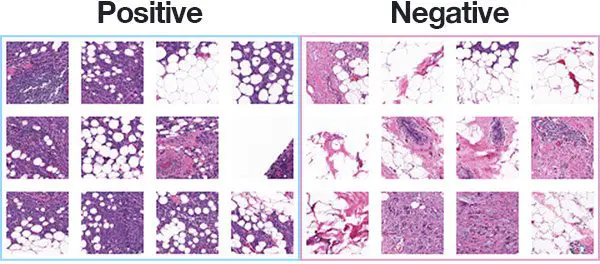

Our goal is to train a deep leanring model capable of descerning the difference between the two classes.

## Prepare dataset

We use a small part of the orginal dataset, containing 20,710 images, including 3 sets:
- training set: 14,912 image
- valdation set: 1,656 image
- test set: 4,142 image


In [ ]:
    INPUT_DATASET = "./datasets/original-small"
    BASE_PATH = "./datasets/idc-small"
    
    TRAIN_PATH = os.path.sep.join([BASE_PATH, "training"])
    VAL_PATH = os.path.sep.join([BASE_PATH, "validation"])
    TEST_PATH = os.path.sep.join([BASE_PATH, "test"])

In [ ]:
    """INPUT_DATASET = "./datasets/20-patientIds"
    BASE_PATH = "./datasets/idc-20patientIds"
    
    TRAIN_PATH = os.path.sep.join([BASE_PATH, "training"])
    VAL_PATH = os.path.sep.join([BASE_PATH, "validation"])
    TEST_PATH = os.path.sep.join([BASE_PATH, "test"])

    TRAIN_SPLIT = 0.8
    VAL_SPLIT = 0.1
    
    
    original_path_list = list(paths.list_images(INPUT_DATASET))
    
    random.seed(7)
    random.shuffle(original_path_list)

    index = int(len(original_path_list) * TRAIN_SPLIT)
    train_path_list = original_path_list[:index]
    test_path_list = original_path_list[index:]

    index = int(len(train_path_list) * VAL_SPLIT)
    val_path_list = train_path_list[:index]
    train_path_list = train_path_list[index:]

    datasets = [("training", train_path_list, TRAIN_PATH),
                ("validation", val_path_list, VAL_PATH),
                ("test", test_path_list, TEST_PATH)]
"""


'INPUT_DATASET = "./datasets/20-patientIds"\nBASE_PATH = "./datasets/idc-20patientIds"\n\nTRAIN_PATH = os.path.sep.join([BASE_PATH, "training"])\nVAL_PATH = os.path.sep.join([BASE_PATH, "validation"])\nTEST_PATH = os.path.sep.join([BASE_PATH, "test"])\n\nTRAIN_SPLIT = 0.8\nVAL_SPLIT = 0.1\n\n\noriginal_path_list = list(paths.list_images(INPUT_DATASET))\n\nrandom.seed(7)\nrandom.shuffle(original_path_list)\n\nindex = int(len(original_path_list) * TRAIN_SPLIT)\ntrain_path_list = original_path_list[:index]\ntest_path_list = original_path_list[index:]\n\nindex = int(len(train_path_list) * VAL_SPLIT)\nval_path_list = train_path_list[:index]\ntrain_path_list = train_path_list[index:]\n\ndatasets = [("training", train_path_list, TRAIN_PATH),\n            ("validation", val_path_list, VAL_PATH),\n            ("test", test_path_list, TEST_PATH)]\n'

In [ ]:
 """   for (set_type, original_path, base_path) in datasets:
        print(f'Building {set_type} set')

        if not os.path.exists(base_path):
            print(f'Building directory {base_path}')
            os.makedirs(base_path)

        for path in original_path:
            file = path.split(os.path.sep)[-1]
            label = file[-5:-4]

            label_path = os.path.sep.join([base_path, label])
            if not os.path.exists(label_path):
                print(f'Building directory {label_path}')
                os.makedirs(label_path)

            new_path = os.path.sep.join([label_path, file])
            shutil.copy2(path, new_path)


"""

"   for (set_type, original_path, base_path) in datasets:\n       print(f'Building {set_type} set')\n\n       if not os.path.exists(base_path):\n           print(f'Building directory {base_path}')\n           os.makedirs(base_path)\n\n       for path in original_path:\n           file = path.split(os.path.sep)[-1]\n           label = file[-5:-4]\n\n           label_path = os.path.sep.join([base_path, label])\n           if not os.path.exists(label_path):\n               print(f'Building directory {label_path}')\n               os.makedirs(label_path)\n\n           new_path = os.path.sep.join([label_path, file])\n           shutil.copy2(path, new_path)\n\n\n"

In [ ]:
    TRAIN_SIZE = len(list(paths.list_images(TRAIN_PATH)))
    VAL_SIZE = len(list(paths.list_images(VAL_PATH)))
    TEST_SIZE = len(list(paths.list_images(TEST_PATH)))


In [ ]:
train_generator = ImageDataGenerator(rescale=1./255,
                                    rotation_range=20,
                                    zoom_range=0.05,
                                    width_shift_range=0.1,
                                    height_shift_range=0.1,
                                    shear_range=0.05,
                                    horizontal_flip=True,
                                    vertical_flip=True,
                                    fill_mode = "nearest"
                                    )
val_generator = ImageDataGenerator(rescale=1./255)
train_gen = train_generator.flow_from_directory(TRAIN_PATH,
                                                class_mode='categorical',
                                                target_size=(48, 48),
                                                shuffle=True,
                                                batch_size=32,
                                                )


# initialize the validation generator
val_gen = val_generator.flow_from_directory(VAL_PATH,
                                            class_mode="categorical",
                                            target_size=(48, 48),
                                            shuffle=False,
                                            batch_size=32)
# initialize the testing generator
test_gen = val_generator.flow_from_directory(TEST_PATH,
                                            class_mode="categorical",
                                            target_size=(48, 48),
                                            shuffle=False,
                                            batch_size=32)


Found 14912 images belonging to 2 classes.
Found 1656 images belonging to 2 classes.
Found 4142 images belonging to 2 classes.


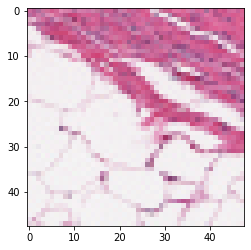

In [ ]:
x,y = test_gen.__getitem__(0)
plt.imshow(x[0])

In [ ]:
def get_class_weight(train_path):


    TRAIN_PATHS = list(paths.list_images(train_path))

    train_labels = [int(p.split(os.path.sep)[-2]) for p in TRAIN_PATHS]
    train_labels = to_categorical(train_labels)

    class_totals = np.sum(train_labels, axis=0)

    class_weight = {}
    for i in range(len(class_totals)):
        class_weight[i] = class_totals.max() / class_totals[i]  
    return class_weight


In [ ]:
class_weight = get_class_weight(TRAIN_PATH)
class_weight

{0: 1.0, 1: 3.261789}

# Build the model

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SeparableConv2D, BatchNormalization, MaxPooling2D, Dropout, Flatten, Dense

In [ ]:
from tensorflow.keras.callbacks import CSVLogger

In [ ]:
from tensorflow.keras import backend as K

In [ ]:
from tensorflow.keras.optimizers import Adagrad

In [ ]:
class CancerNet:
    @staticmethod
    def build(width, height, depth, classes):
        # initialize model along with input shape to be "channels last" and channels dimension ifself
        model = Sequential()
        input_shape = (height, width, depth)
        chan_dim = -1

        if K.image_data_format() == "channel_firsts":
            input_shape = (depth, height, width)
            chan_dim = 1
        # CONV => RELU => POOL
        model.add(SeparableConv2D(32, (3,3), padding='same', activation='relu', input_shape = input_shape))
        model.add(BatchNormalization(axis=chan_dim))
        model.add(MaxPooling2D(pool_size=(2,2)))
        model.add(Dropout(0.25))

        # (CONV => RELU => POOL) * 2

        model.add(SeparableConv2D(64, (3, 3), padding="same", activation='relu'))
        model.add(BatchNormalization(axis=chan_dim))

        model.add(SeparableConv2D(64, (3, 3), padding="same", activation='relu'))
        model.add(BatchNormalization(axis=chan_dim))
        model.add(MaxPooling2D(pool_size=(2, 2)))
        model.add(Dropout(0.25))
        # (CONV => RELU => POOL) * 3
        model.add(SeparableConv2D(128, (3, 3), padding="same", activation='relu'))
        model.add(BatchNormalization(axis=chan_dim))

        model.add(SeparableConv2D(128, (3, 3), padding="same", activation='relu'))
        model.add(BatchNormalization(axis=chan_dim))
        model.add(SeparableConv2D(128, (3, 3), padding="same", activation='relu'))

        model.add(BatchNormalization(axis=chan_dim))
        model.add(MaxPooling2D(pool_size=(2, 2)))
        model.add(Dropout(0.25))

        # Flatten
        model.add(Flatten())
        model.add(Dense(256, activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(0.5))

        # Softmax
        model.add(Dense(classes, activation='softmax'))

        return model


In [ ]:
NUM_EPOCHS = 40
INIT_LEARNING_RATE = 1e-2
BATCH_SIZE = 32


optimizer = Adagrad(learning_rate=INIT_LEARNING_RATE, decay= INIT_LEARNING_RATE/NUM_EPOCHS)

model = CancerNet.build(48, 48, 3, 2)
model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

model.summary()

# Train the model

In [ ]:
csv_logger = CSVLogger(filename='./models/training_log.csv', append=True)

In [ ]:
H = model.fit(train_gen,
              steps_per_epoch=TRAIN_SIZE//BATCH_SIZE,
              validation_data=val_gen,
              validation_steps = VAL_SIZE//BATCH_SIZE,
              class_weight=class_weight,
              epochs=20,
              callbacks=[csv_logger]
              )

Epoch 1/20
466/466 [==============================] - 41s 88ms/step - loss: 0.5819 - accuracy: 0.8336 - val_loss: 0.4172 - val_accuracy: 0.8027
Epoch 2/20
466/466 [==============================] - 40s 87ms/step - loss: 0.5741 - accuracy: 0.8362 - val_loss: 0.4042 - val_accuracy: 0.8156
Epoch 3/20
466/466 [==============================] - 40s 86ms/step - loss: 0.5813 - accuracy: 0.8353 - val_loss: 0.4268 - val_accuracy: 0.7972
Epoch 4/20
466/466 [==============================] - 40s 85ms/step - loss: 0.5790 - accuracy: 0.8372 - val_loss: 0.4239 - val_accuracy: 0.8009
Epoch 5/20
466/466 [==============================] - 40s 86ms/step - loss: 0.5721 - accuracy: 0.8382 - val_loss: 0.4249 - val_accuracy: 0.8009
Epoch 6/20
466/466 [==============================] - 40s 85ms/step - loss: 0.5707 - accuracy: 0.8342 - val_loss: 0.4139 - val_accuracy: 0.8107
Epoch 7/20
466/466 [==============================] - 39s 84ms/step - loss: 0.5709 - accuracy: 0.8377 - val_loss: 0.4298 - val_accuracy:

# Evaluate the model

In [ ]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix


In [ ]:
# plot the training loss and accuracy

def plot_history(H):
    plt.style.use("ggplot")
    plt.figure()
    plt.plot(np.arange(0, NUM_EPOCHS), H.history["loss"], label="train_loss")
    plt.plot(np.arange(0, NUM_EPOCHS), H.history["val_loss"], label="val_loss")
    plt.plot(np.arange(0, NUM_EPOCHS), H.history["accuracy"], label="train_acc")
    plt.plot(np.arange(0, NUM_EPOCHS), H.history["val_accuracy"], label="val_acc")
    plt.title("Training Loss and Accuracy on Dataset")
    plt.xlabel("Epoch #")
    plt.ylabel("Loss/Accuracy")
    plt.legend(loc="lower left")
    #plt.savefig(args["plot"])
    plt.show()
def evaluate():
    prediction = model.predict(x=test_gen, steps=(TEST_SIZE)//BATCH_SIZE + 1)
    prediction = np.argmax(prediction, axis=1)
    print(classification_report(test_gen.classes, prediction,
                                  target_names=test_gen.class_indices.keys()))
    # compute the confusion matrix and and use it to derive the raw
    # accuracy, sensitivity, and specificity
    cm = confusion_matrix(test_gen.classes, prediction)
    total = sum(sum(cm))
    acc = (cm[0, 0] + cm[1, 1]) / total
    sensitivity = cm[0, 0] / (cm[0, 0] + cm[0, 1])
    specificity = cm[1, 1] / (cm[1, 0] + cm[1, 1])
    # show the confusion matrix, accuracy, sensitivity, and specificity
    print(cm)
    print("acc: {:.4f}".format(acc))
    print("sensitivity: {:.4f}".format(sensitivity))
    print("specificity: {:.4f}".format(specificity))

In [ ]:
evaluate()

              precision    recall  f1-score   support

           0       0.89      0.87      0.88      3168
           1       0.61      0.64      0.62       974

    accuracy                           0.82      4142
   macro avg       0.75      0.75      0.75      4142
weighted avg       0.82      0.82      0.82      4142

[[2767  401]
 [ 355  619]]
acc: 0.8175
sensitivity: 0.8734
specificity: 0.6355


In [ ]:
    prediction = model.predict(x=test_gen, steps=(TEST_SIZE)//BATCH_SIZE + 1)
    prediction = np.argmax(prediction, axis=1)

[[2858  310]
 [ 327  647]]
acc: 0.8462
sensitivity: 0.9021
specificity: 0.6643


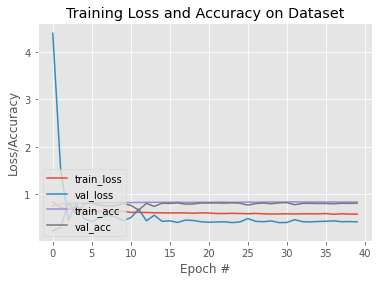

In [ ]:
plot_history(H)

In [ ]:
def plot_accuracy_and_loss(history):  
    # list all data in history
    print(history.history.keys())
    # summarize history for accuracy
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='bottom_left')
    plt.show();
    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='bottom_left')
    plt.show();

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: MatplotlibDeprecationWarning: Unrecognized location 'bottom_left'. Falling back on 'best'; valid locations are
	best
	upper right
	upper left
	lower left
	lower right
	right
	center left
	center right
	lower center
	upper center
	center
This will raise an exception in 3.3.
  # Remove the CWD from sys.path while we load stuff.


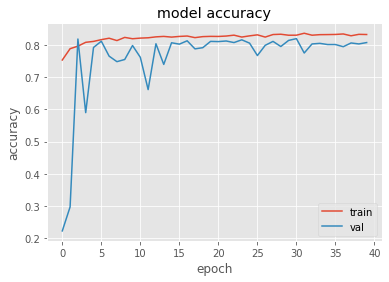

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: Unrecognized location 'bottom_left'. Falling back on 'best'; valid locations are
	best
	upper right
	upper left
	lower left
	lower right
	right
	center left
	center right
	lower center
	upper center
	center
This will raise an exception in 3.3.


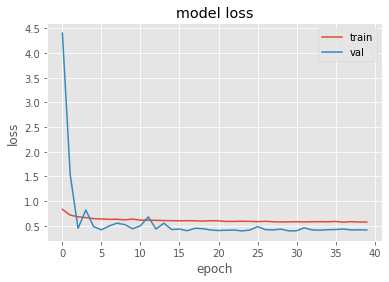

In [ ]:
plot_accuracy_and_loss(H)